In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
words = open('names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [30]:
# build the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])    # 80% of the data
Xva, Yva = build_dataset(words[n1:n2])  # 10% of the data
Xte, Yte = build_dataset(words[n2:])    # 10% of the data

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [31]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),                 generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),     generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                            generator=g) * 0.02
W2 = torch.randn((n_hidden, vocab_size),              generator=g) * 0.02
b2 = torch.randn(vocab_size,                          generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [32]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch generation
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # batch norm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch normalization

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # non-linearity
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #break

      0/200000: 3.3220
  10000/200000: 1.7985
  20000/200000: 1.8875
  30000/200000: 2.4675
  40000/200000: 2.4419
  50000/200000: 1.8908
  60000/200000: 2.4219
  70000/200000: 2.1415
  80000/200000: 1.7474
  90000/200000: 2.3167
 100000/200000: 2.2264
 110000/200000: 2.1789
 120000/200000: 1.9721
 130000/200000: 1.7997
 140000/200000: 2.2558
 150000/200000: 2.2249
 160000/200000: 1.9076
 170000/200000: 2.1831
 180000/200000: 2.6187
 190000/200000: 1.8218


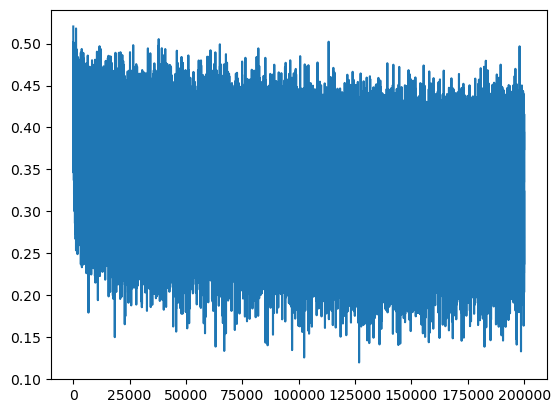

In [22]:
plt.plot(lossi)

In [33]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through the network
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = - hpreact.std(0, keepdim=True)

In [36]:
@torch.no_grad()
def split_loss(split):
    x,y = {
    'tr': (Xtr,Ytr),
    'va': (Xva,Yva),
    'te': (Xte,Yte)
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # batch normalization
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('tr')
split_loss('va')

tr 2.0645408630371094
va 2.123572826385498


In [12]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 50)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        # forward pass
        emb = C[torch.tensor(context).unsqueeze(0)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution
        ix = torch.multinomial(probs.view(-1), 1, generator=g).item()
        # shift the context
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special end-of-word token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out[:-1]))

braika
keion
wukie
han
moxi
kyyrissela
kaylorian
mayafita
zona
ader
nathirameirapharlis
nif
navorelynn
lydin
benz
lock
arion
marakenni
aleianiya
ilya
